In VQ-VAE has an encoder and a decoder like AE and VAE. the main difference comes in latent sapace where the latent vector are discrete. in VAE and AE the latent space is contionus but in Vq-VAE we have $K$ discrete latent vector named dictionary. the dinal latent representation of input is one of these $K$ vector. This discretization helps in genrating samples more roubust. for example when we have different categories the contionous representation is not good becasue every latent vector can not be end to a realsitc image. but here with discretzation we can produce more realistic iamges becasue we know ecxaly every category has what latent representation.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
from matplotlib.animation import FuncAnimation
from functools import partial
import os

In [2]:
mnist_transforms = transforms.Compose([transforms.ToTensor()])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

trainset = MNIST('.',train=True, transform=mnist_transforms, download=True)
testset = MNIST('.',train=False, transform=mnist_transforms, download=True)
trainLoader = DataLoader(trainset, batch_size,shuffle=True)
testLoader = DataLoader(testset, batch_size,shuffle=True)

In [3]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(channels, channels, 3, 1, 1),
                                    nn.ReLU(), nn.BatchNorm2d(channels),
                                   nn.Conv2d(channels, channels, 3, 1, 1),
                                   nn.ReLU(), nn.BatchNorm2d(channels))
    def forward(self, x):
        return x + self.block(x)

class Codebook(nn.Module):
    def __init__(self, K, hidden_dim):
        super().__init__()
        self.embedding = nn.Parameter(2/K * torch.rand(K,hidden_dim) - 1/K) # uniform intialization
    
    def forward(self, ze:torch.tensor):
        B, c, h, w = ze.shape
        ze = ze.permute(0,2,3,1).reshape(-1, c)
        ze_d = ze.detach()
        dist = torch.cdist(ze_d, self.embedding[None,:,:])
        e = self.embedding[dist.argmin(dim=-1)]
        zq = ze + (e - ze_d).detach()
        zq = zq.reshape(B, h, w, c).permute(0,3,1,2)
        e = e.reshape(B, h, w, c).permute(0,3,1,2)
        return zq, e

class VQ_VAE(nn.Module):
    def __init__(self, in_channels, hidden_dim, K):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels, hidden_dim, 3, 2, 1), nn.ReLU(), nn.BatchNorm2d(hidden_dim), 
                                     ResBlock(hidden_dim),
                                     nn.Conv2d(hidden_dim, hidden_dim, 3, 2, 1), nn.ReLU(), nn.BatchNorm2d(hidden_dim), 
                                     ResBlock(hidden_dim)) # B x 2 x 7 x 7
        
        self.codebook = Codebook(K, hidden_dim)

        self.decoder = nn.Sequential(ResBlock(hidden_dim), 
                                     nn.ConvTranspose2d(hidden_dim, in_channels, 4, 2, 1), nn.BatchNorm2d(in_channels), nn.ReLU(),
                                     ResBlock(in_channels),
                                     nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1), nn.BatchNorm2d(in_channels), nn.Sigmoid())

    
    def forward(self, x):
        ze = self.encoder(x)
        zq, e = self.codebook(ze)
        y = self.decoder(zq)
        return y, ze, e


In [4]:
def train_model(model, epoch_num, optimizer, trainLoader):
    losses = []
    images = []
    outputs = []
    codes = []
    latents = []
    for epoch in range(epoch_num):
        total_loss = 0.0
        for i, (img, target) in tqdm(enumerate(trainLoader), total=len(trainLoader), desc=f'epoch {epoch}'):
            optimizer.zero_grad()

            img = img.to(device)
            target = target.to(device)

            y, ze, e = model(img)
            loss = F.mse_loss(y,img) + F.mse_loss(ze.detach(),e) + 1.5 * F.mse_loss(ze, e.detach())
            
            loss.backward()
            optimizer.step()

            if i%100 == 0:
                total_loss += loss.item()
                images.append(img[0,:,:,:].detach().cpu())
                outputs.append(y[0,:,:,:].detach().cpu())
                #codes.append(e[0,:,:,:].detach().cpu())
                #latents.append(model.codebook.embedding.detach().cpu())
        
        total_loss /= len(trainLoader)
        losses.append(total_loss)
        print(f'loss: {total_loss}')
    
    return losses, images, outputs, codes, latents


epoch 0: 100%|██████████| 1875/1875 [00:23<00:00, 78.13it/s]


loss: 0.03397163602511088


epoch 1: 100%|██████████| 1875/1875 [00:20<00:00, 92.06it/s]


loss: 0.008194611245393753


epoch 2: 100%|██████████| 1875/1875 [00:20<00:00, 91.46it/s]


loss: 0.006834958730141322


epoch 3: 100%|██████████| 1875/1875 [00:21<00:00, 89.05it/s]


loss: 0.006794125211238861


epoch 4: 100%|██████████| 1875/1875 [00:20<00:00, 90.26it/s]


loss: 0.006470064767201742


epoch 5: 100%|██████████| 1875/1875 [00:20<00:00, 91.66it/s]


loss: 0.006343611514568329


epoch 6: 100%|██████████| 1875/1875 [00:20<00:00, 89.55it/s]


loss: 0.006222450564304987


epoch 7: 100%|██████████| 1875/1875 [00:20<00:00, 91.35it/s]


loss: 0.006233532659212749


epoch 8: 100%|██████████| 1875/1875 [00:21<00:00, 89.14it/s]


loss: 0.006207156205177307


epoch 9: 100%|██████████| 1875/1875 [00:20<00:00, 89.30it/s]


loss: 0.0059257616837819415


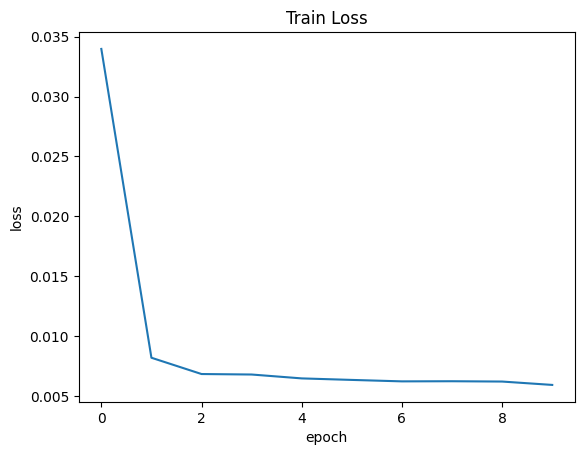

In [6]:
model = VQ_VAE(1,2,3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_num = 10

losses, images, outputs, codes, latents = train_model(model, epoch_num, optimizer, trainLoader)

plt.figure()
plt.plot(range(epoch_num),losses)
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

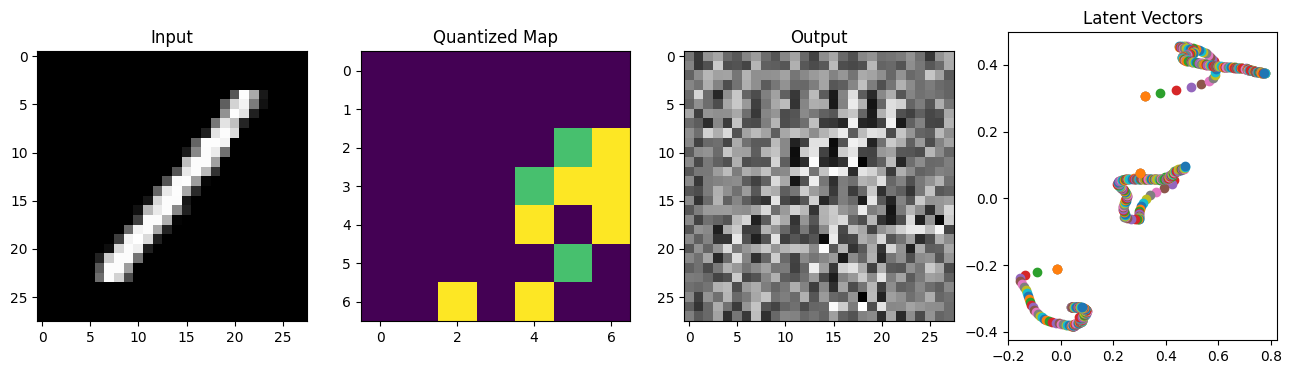

In [57]:
step = len(images) // 200
def update(frame, ax):
    ax[0].imshow(images[frame*step].permute((1,2,0)), cmap='gray')
    ax[0].set_title('Input')

    ax[3].scatter(latents[frame*step][:,0], latents[frame][:,1])
    ax[3].set_title('Latent Vectors')

    ax[1].imshow(codes[frame*step].permute((1,2,0)).mean(dim=-1), cmap='viridis')
    ax[1].set_title('Quantized Map')

    ax[2].imshow(outputs[frame*step].permute((1,2,0)).mean(dim=-1), cmap='gray')
    ax[2].set_title('Output')
    return ax

fig, ax = plt.subplots(1, 4, figsize=(16,4))
num_frames = len(images)
animation = FuncAnimation(fig, partial(update, ax=ax), frames=200, interval=100)
animation.save('output_gray.gif')


In [5]:
class RGBDataset(Dataset):
    def __init__(self, data, targets):
        super().__init__()
        self.data = data
        self.targets = targets
    
    def __getitem__(self, index):
        img = self.data[index][None,:,:] * torch.rand(3,1,1)
        target = self.targets[index]
        return img, target
    
    def __len__(self):
        return len(self.data)

In [6]:
trainset_new = RGBDataset(trainset.data, trainset.targets)
testset_new = RGBDataset(testset.data, testset.targets)

trainLoader_new = DataLoader(trainset_new, batch_size, shuffle=True)
testLoader_new = DataLoader(testset_new, batch_size, shuffle=True)

In [9]:
def update_new(frame, ax, step, images, outputs):
    ax[0].imshow(images[frame*step].permute((1,2,0)), cmap='gray')
    ax[0].set_title('Input')

    ax[1].imshow(outputs[frame*step].permute((1,2,0)), cmap='gray')
    ax[1].set_title('Output')
    return ax

def create_gif(images, outputs, name):
    step = len(images) // 100
    fig, ax = plt.subplots(1, 2, figsize=(8,2))
    animation = FuncAnimation(fig, partial(update_new, ax=ax, step=step, images=images, outputs=outputs), frames=100, interval=100)
    animation.save(name)

epoch 0: 100%|██████████| 1875/1875 [00:26<00:00, 72.01it/s] 


loss: 24.289928059895832


epoch 1: 100%|██████████| 1875/1875 [00:18<00:00, 103.08it/s]


loss: 23.53082421875


epoch 2: 100%|██████████| 1875/1875 [00:18<00:00, 103.16it/s]


loss: 24.9865828125


epoch 3: 100%|██████████| 1875/1875 [00:18<00:00, 103.06it/s]


loss: 23.466023567708334


epoch 4: 100%|██████████| 1875/1875 [00:18<00:00, 102.91it/s]


loss: 24.231168489583332


epoch 5: 100%|██████████| 1875/1875 [00:18<00:00, 102.77it/s]


loss: 23.762752734375


epoch 6: 100%|██████████| 1875/1875 [00:18<00:00, 103.05it/s]


loss: 24.424554557291668


epoch 7: 100%|██████████| 1875/1875 [00:18<00:00, 103.00it/s]


loss: 25.954238020833333


epoch 8: 100%|██████████| 1875/1875 [00:18<00:00, 102.61it/s]


loss: 25.326161458333335


epoch 9: 100%|██████████| 1875/1875 [00:18<00:00, 103.50it/s]


loss: 24.100467578125
creating gif for K=3...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

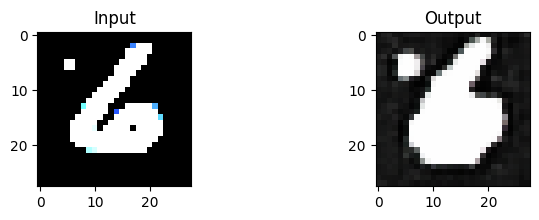

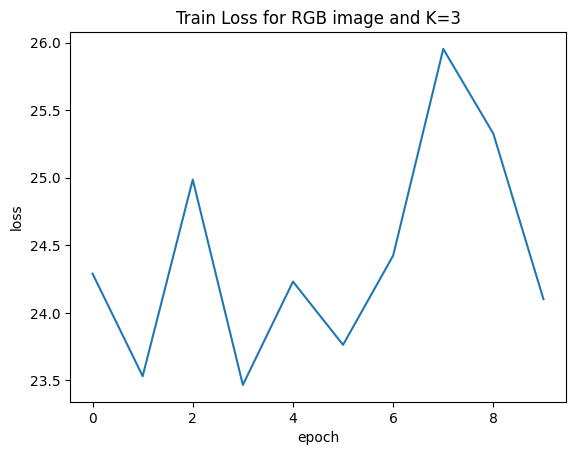

epoch 0: 100%|██████████| 1875/1875 [00:17<00:00, 105.89it/s]


loss: 24.751967708333332


epoch 1: 100%|██████████| 1875/1875 [00:17<00:00, 106.74it/s]


loss: 24.412508463541666


epoch 2: 100%|██████████| 1875/1875 [00:17<00:00, 104.18it/s]


loss: 24.531825325520835


epoch 3: 100%|██████████| 1875/1875 [00:18<00:00, 104.11it/s]


loss: 22.818842252604167


epoch 4: 100%|██████████| 1875/1875 [00:17<00:00, 104.26it/s]


loss: 23.9732330078125


epoch 5: 100%|██████████| 1875/1875 [00:17<00:00, 106.80it/s]


loss: 24.367396940104168


epoch 6: 100%|██████████| 1875/1875 [00:18<00:00, 102.49it/s]


loss: 24.322568619791667


epoch 7: 100%|██████████| 1875/1875 [00:18<00:00, 102.84it/s]


loss: 23.977946940104168


epoch 8: 100%|██████████| 1875/1875 [00:18<00:00, 102.63it/s]


loss: 24.3305689453125


epoch 9: 100%|██████████| 1875/1875 [00:18<00:00, 102.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 24.0189130859375
creating gif for K=15...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

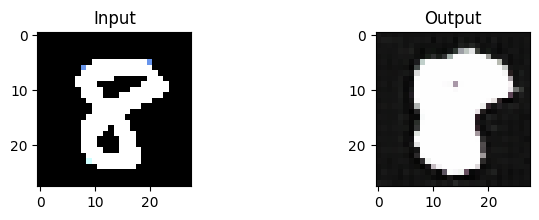

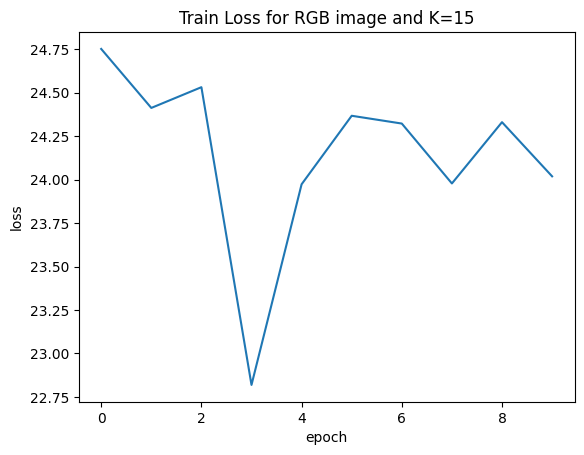

epoch 0: 100%|██████████| 1875/1875 [00:17<00:00, 108.13it/s]


loss: 23.200485221354167


epoch 1: 100%|██████████| 1875/1875 [00:17<00:00, 104.46it/s]


loss: 24.618640625


epoch 2: 100%|██████████| 1875/1875 [00:17<00:00, 104.26it/s]


loss: 25.156150520833332


epoch 3: 100%|██████████| 1875/1875 [00:18<00:00, 101.57it/s]


loss: 24.849683854166667


epoch 4: 100%|██████████| 1875/1875 [00:18<00:00, 101.86it/s]


loss: 24.082445052083333


epoch 5: 100%|██████████| 1875/1875 [00:18<00:00, 103.82it/s]


loss: 24.640974609375


epoch 6: 100%|██████████| 1875/1875 [00:18<00:00, 103.54it/s]


loss: 24.700363411458333


epoch 7: 100%|██████████| 1875/1875 [00:18<00:00, 103.86it/s]


loss: 24.471661979166665


epoch 8: 100%|██████████| 1875/1875 [00:17<00:00, 104.26it/s]


loss: 24.208074739583335


epoch 9: 100%|██████████| 1875/1875 [00:17<00:00, 104.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 25.187422981770833
creating gif for K=30...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

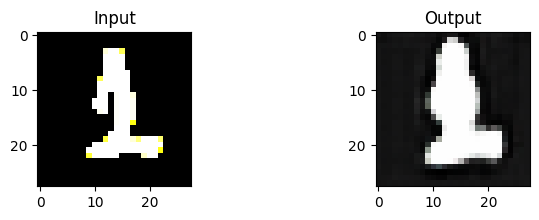

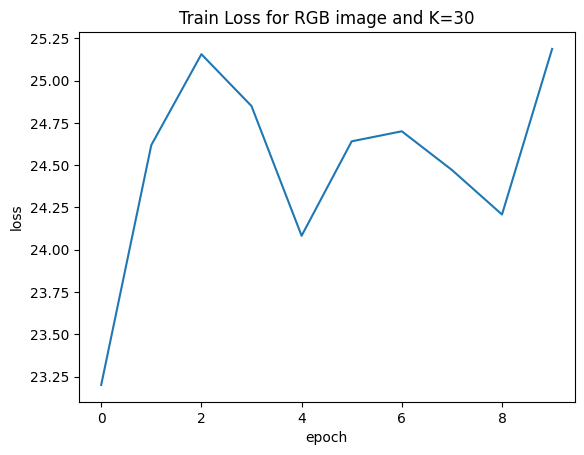

epoch 0: 100%|██████████| 1875/1875 [00:17<00:00, 107.73it/s]


loss: 23.708917513020833


epoch 1: 100%|██████████| 1875/1875 [00:17<00:00, 108.53it/s]


loss: 24.8681751953125


epoch 2: 100%|██████████| 1875/1875 [00:17<00:00, 108.52it/s]


loss: 25.040064192708332


epoch 3: 100%|██████████| 1875/1875 [00:17<00:00, 104.76it/s]


loss: 24.479025065104167


epoch 4: 100%|██████████| 1875/1875 [00:17<00:00, 104.17it/s]


loss: 24.831427734375


epoch 5: 100%|██████████| 1875/1875 [00:17<00:00, 104.69it/s]


loss: 25.275907682291667


epoch 6: 100%|██████████| 1875/1875 [00:18<00:00, 104.08it/s]


loss: 23.370830078125


epoch 7: 100%|██████████| 1875/1875 [00:18<00:00, 103.94it/s]


loss: 23.5636892578125


epoch 8: 100%|██████████| 1875/1875 [00:18<00:00, 103.60it/s]


loss: 24.120051041666667


epoch 9: 100%|██████████| 1875/1875 [00:18<00:00, 103.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 22.761528059895834
creating gif for K=50...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

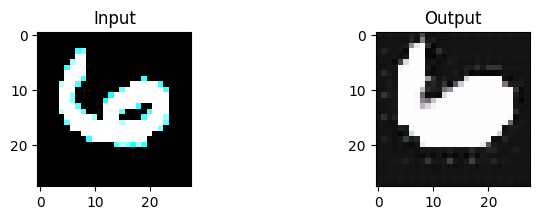

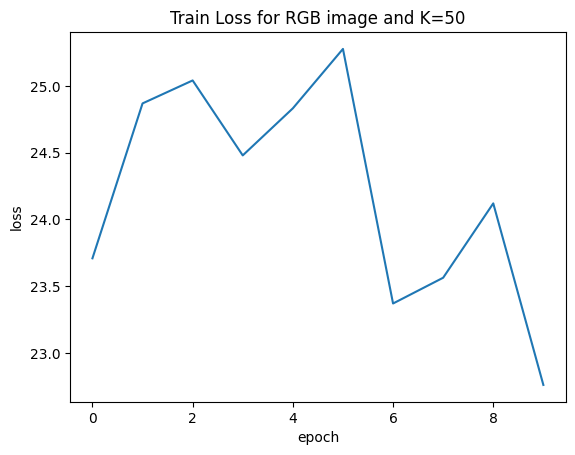

In [10]:
K= [3, 15, 30, 50]

for k in K:
    model = VQ_VAE(in_channels=3, hidden_dim=2, K=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epoch_num = 10

    losses, images, outputs, _, _ = train_model(model, epoch_num, optimizer, trainLoader_new)
    print(f'creating gif for K={k}...')
    create_gif(images, outputs, f'rgb_k={k}_d=2.gif')

    plt.figure()
    plt.plot(range(epoch_num),losses)
    plt.title(f'Train Loss for RGB image and K={k}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

epoch 0: 100%|██████████| 1875/1875 [00:18<00:00, 101.19it/s]


loss: 23.7813240234375


epoch 1: 100%|██████████| 1875/1875 [00:18<00:00, 101.82it/s]


loss: 25.111874869791666


epoch 2: 100%|██████████| 1875/1875 [00:18<00:00, 102.39it/s]


loss: 23.949409895833334


epoch 3: 100%|██████████| 1875/1875 [00:18<00:00, 102.67it/s]


loss: 24.78602890625


epoch 4: 100%|██████████| 1875/1875 [00:18<00:00, 102.21it/s]


loss: 24.376365625


epoch 5: 100%|██████████| 1875/1875 [00:18<00:00, 102.85it/s]


loss: 24.052335611979167


epoch 6: 100%|██████████| 1875/1875 [00:18<00:00, 102.87it/s]


loss: 24.802874934895833


epoch 7: 100%|██████████| 1875/1875 [00:18<00:00, 103.44it/s]


loss: 24.144679947916668


epoch 8: 100%|██████████| 1875/1875 [00:18<00:00, 103.11it/s]


loss: 24.1111966796875


epoch 9: 100%|██████████| 1875/1875 [00:18<00:00, 102.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 24.2143052734375
creating gif for K=50...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

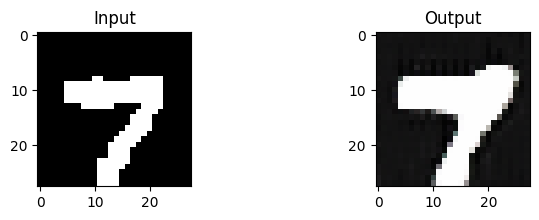

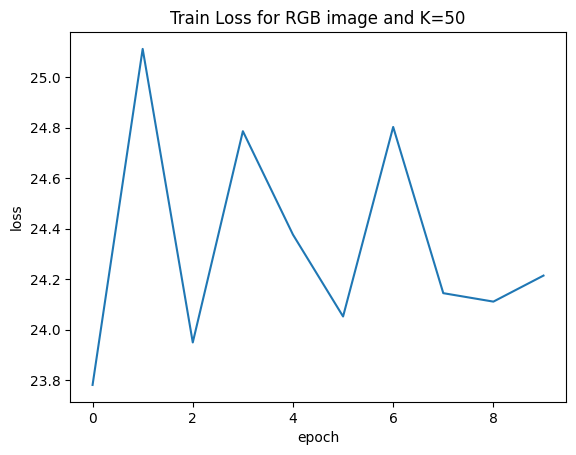

In [11]:
model = VQ_VAE(in_channels=3, hidden_dim=50, K=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_num = 10

losses, images, outputs, _, _ = train_model(model, epoch_num, optimizer, trainLoader_new)
print(f'creating gif for K={k}...')
create_gif(images, outputs, f'rgb_k=3_d=50.gif')

plt.figure()
plt.plot(range(epoch_num),losses)
plt.title(f'Train Loss for RGB image and K={k}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

As we can see, with increassinng the number of latent vectors the representation is more accurate since we can difference between more categories and gropus. also with increasing the number of dimentiality the representation is more richer and can encode more information but it suffers from low components. Also the predicted output is not good as the gray dataset and that is obvious becasue we change the real images in a random way